In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import when  
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.mllib.clustering import KMeans, KMeansModel
import pyspark.mllib
from numpy import array
from math import sqrt
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from pyspark.sql import SQLContext as hv
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import StringType

In [2]:
PWD = !pwd
PWD = PWD[0]
from pyspark.sql import SparkSession
app_name = "project"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [3]:
rdd_train = sc.textFile('gs://w261hw/train.txt').map(lambda r : r.split('\t'))

In [4]:
#df=rdd_train.toDF().limit(2000).cache()
df=rdd_train.toDF()


In [20]:
#Store the original columns
df_schema=df.schema
cols = df.columns
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
_1,0,0,0,0,0
_2,1,2,2,,3
_3,1,0,0,893,-1
_4,5,44,1,,
_5,0,1,14,,0
_6,1382,102,767,4392,2
_7,4,8,89,,0
_8,15,2,4,0,3
_9,2,2,2,0,0
_10,181,4,245,0,0


In [5]:
#Get numeric and categorical column names
numericCols = df.columns[1:14]
categoricalColumns = df.columns[14:40]

print(numericCols)
print(categoricalColumns)

['_2', '_3', '_4', '_5', '_6', '_7', '_8', '_9', '_10', '_11', '_12', '_13', '_14']
['_15', '_16', '_17', '_18', '_19', '_20', '_21', '_22', '_23', '_24', '_25', '_26', '_27', '_28', '_29', '_30', '_31', '_32', '_33', '_34', '_35', '_36', '_37', '_38', '_39', '_40']


In [6]:
df_bkp=df

In [7]:
df=df_bkp
from pyspark.sql.types import IntegerType,StringType
from pyspark.sql.functions import udf
#df = df.replace('',None)
def rep_fu(x):
    ret=x
    if x.strip()=='':
        ret=0
    return ret  

def rep_fu_string(x):
    ret=x
    if x.strip()=='':
        ret='__Dummy__'
    return ret

rep_fun_new=udf(rep_fu)
rep_fun_string=udf(rep_fu_string)
df = df.select(*[rep_fun_new(column).alias(column).cast(IntegerType()) if column in numericCols else column for column in df.columns])
df = df.select(*[rep_fun_string(column).alias(column).cast(StringType()) if column in categoricalColumns else column for column in df.columns])


In [24]:
pd.DataFrame(df.take(5),columns=df.columns).transpose()

,0,1,2,3,4
_1,0,0,0,0,0
_2,1,2,2,0,3
_3,1,0,0,893,-1
_4,5,44,1,0,0
_5,0,1,14,0,0
_6,1382,102,767,4392,2
_7,4,8,89,0,0
_8,15,2,4,0,3
_9,2,2,2,0,0
_10,181,4,245,0,0


[Text(0,0.5,u'frequency'), Text(0.5,0,u'Label value'), Text(0.5,1,u'Labels')]

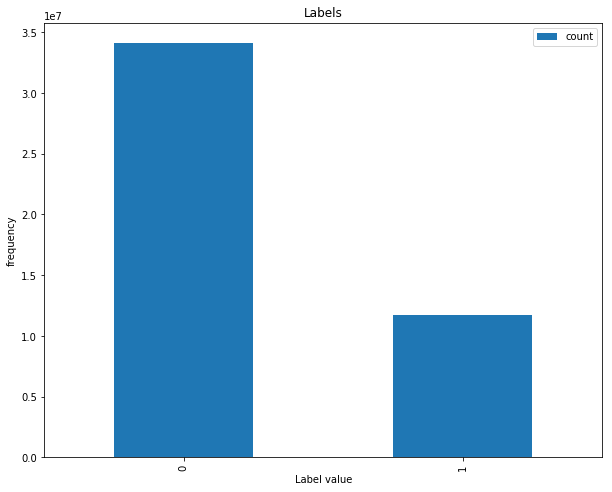

In [ ]:
Labels_counts=df.select("_1").groupBy("_1").count().toPandas()
fig_std=(10,8)
width = 0.4
Labels_counts.plot(kind='bar', figsize=fig_std).set(xlabel='Label value', ylabel='frequency',title='Labels')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0e38c57710>,
      dtype=object)

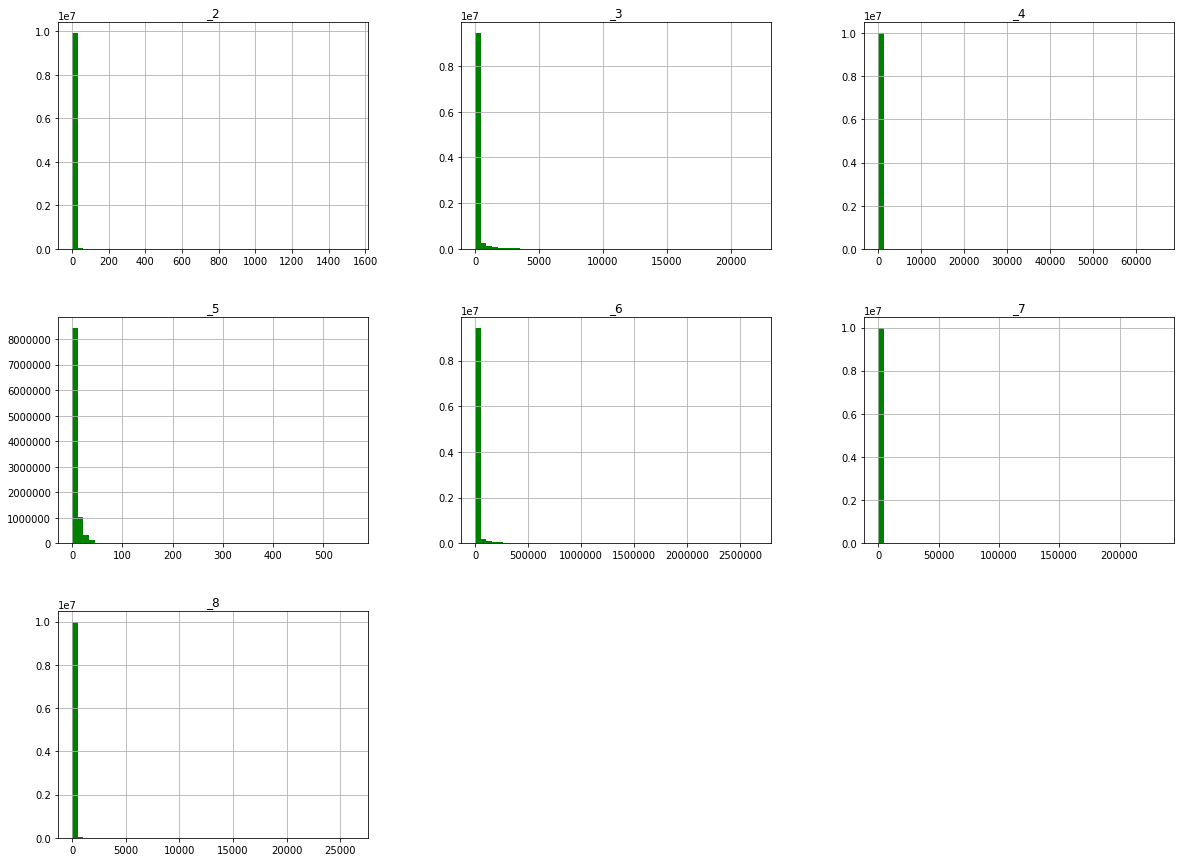

In [37]:
## Histogram of numerical columns (_2 to _14)
data=df.limit(10000000).select(['_2','_3','_4','_5','_6','_7','_8']).toPandas()
data.loc[:, '_2': '_8'].hist(bins=50, figsize=(20,15), color = 'green')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0e385744d0>,
      dtype=object)

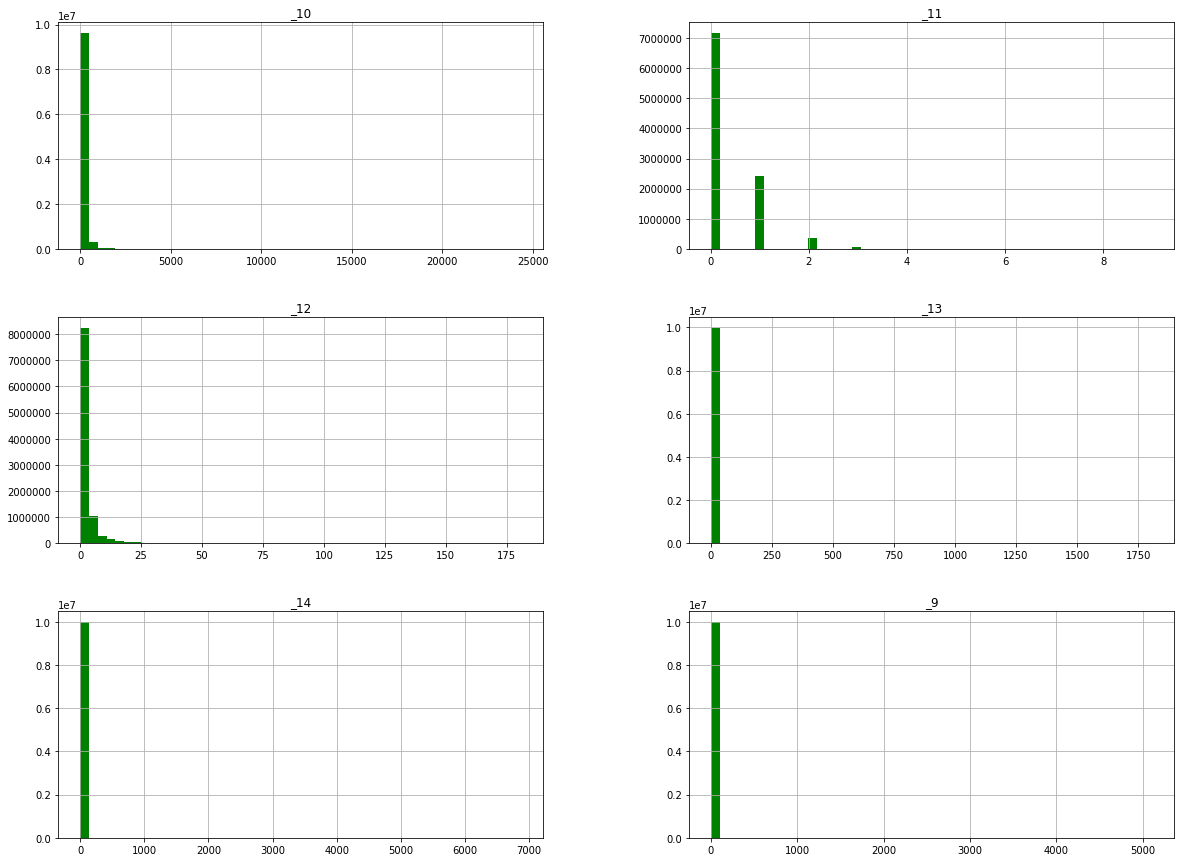

In [39]:
## Histogram of numerical columns (_2 to _14)
data=df.limit(10000000).select(['_9','_10','_11','_12','_13','_14']).toPandas()
data.loc[:, '_9': '_14'].hist(bins=50, figsize=(20,15), color = 'green')

In [ ]:
for i in range(15,40):
   col_name="_"+str(i)
   Labels_counts=df.select([col_name]).limit(1000).groupBy(col_name).count().toPandas()
   row_count=Labels_counts.shape[0]
   fig_std=(10,8)
   width = 0.4
   title_= "for column " + col_name+" , Distinct values are "+str(row_count)
   Labels_counts.plot(kind='bar', figsize=fig_std).set(xlabel='Label value', ylabel='frequency',title=title_)